Tom Halloin <br> Springboard Data Science Career Track <br>

<h1 align="center">Capstone Project 2: Analysis of Berkshire Hathaway Shareholder Letters Using Natural Language Processing (NLP) Techniques</h1>
<h2 align='center'> Part 1: Visualizing Cumulative Returns Using Bokeh</h2> <br>

In [1]:
import bokeh  # Interactive plotting
import gensim  # Topic modeling
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # Linear Algebra
import os  # File locations
import pandas as pd  # Dataframes
import pickle  # Saving and loading files
import pprint  # Pretty printing
import pyLDAvis  # Visualization
import pyLDAvis.gensim  # Notebook visualization
import re  # Regular expressions
import spacy  # Industrial strength machine learning
import textacy  # library that works with SpaCy for preprocessing and postprocessing textual data
import warnings  # For ignoring warnings
warnings.filterwarnings('ignore')

from bokeh import io
from bokeh.io import export_png  # Saving charts
from bokeh.resources import INLINE  # Bokeh for viewing notebooks
from bokeh.plotting import figure, output_file, show  # Outputting bokeh plot at end
from bokeh.models import ColumnDataSource  # Column data source for columns
from bokeh.models.tools import HoverTool  # show each topic weight by year
from bokeh.palettes import Spectral  # Color palette
from bs4 import BeautifulSoup  # HTML library
from gensim import corpora  # Building a corpus of documents
from gensim.models.coherencemodel import CoherenceModel  # Coherence model scoring
from spacy.lang.en import English  # English language
from spacy.lang.en.stop_words import STOP_WORDS  # Stop words
from sumy.nlp.tokenizers import Tokenizer  # Tokenization for summary purposes
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from tabula import read_pdf  # Reading in tables from PDFs
from textacy import preprocessing  # Preprocessing functions
from tqdm.notebook import tqdm  # Fancy progress bars for the impatient

bokeh.io.output_notebook(INLINE)

Loading BokehJS ...

Loading SpaCy libraries. Using the large model because of similarity computation.

In [2]:
nlp = spacy.load("en_core_web_lg")  # For similarity computation

Preparing to read in the returns data with some cleaning to get only the rows and columns needed.

In [3]:
# Read in returns
returns = read_pdf('../Inputs/2019_00.pdf')

# Reset the columns
returns.columns = [
    'Year', 'Drop', 'Berkshire_Price_Change', 'S&P_Plus_Dividends'
]

# Drop the first two rows
returns.drop(returns.index[:2], inplace=True)
returns.drop(['Drop'], axis=1, inplace=True)
returns.reset_index(drop=True)
returns.set_index('Year', inplace=True)

# Drop rows before 1977
returns = returns.loc['1977':]

Negative numbers are in parenthesis, so the function below fixes that. 

In [4]:
def remove_parens(number_as_string):
    '''Removes parenthesis in numbers and turns number negative'''
    left_paren = re.sub(r'\(', '-', number_as_string)
    right_paren = re.sub(r'\)', '', left_paren)
    return right_paren

Uses the function above to remove parenthesis, change the type to all numbers to float, and create columns that show cumulative growth over time.

In [5]:
returns['Berkshire_Price_Change'] = returns['Berkshire_Price_Change'].apply(
    lambda x: remove_parens(x)).values
returns['S&P_Plus_Dividends'] = returns['S&P_Plus_Dividends'].apply(
    lambda x: remove_parens(x)).values
returns = returns.astype('float')

returns['Berkshire_Cumulative_Growth'] = returns[
    'Berkshire_Price_Change'].apply(lambda x: (1 + x / 100))
returns['Berkshire_Cumulative_Growth'] = np.cumprod(
    returns['Berkshire_Cumulative_Growth'])

returns['S&P_Cumulative_Growth'] = returns['S&P_Plus_Dividends'].apply(
    lambda x: (1 + x / 100))
returns['S&P_Cumulative_Growth'] = np.cumprod(returns['S&P_Cumulative_Growth'])

Below is a graph of the returns of investing 1 dollar in Berkshire compared to the S&P 500 since the release of the letters in 1977.

In [6]:
source = ColumnDataSource(returns)
p = figure(title='Growth of $1 since letters released',
           x_axis_label='Year',
           y_axis_label='Amount',
           plot_height=500,
           plot_width=800)

# Plot date along the x axis and price along the y axis
p.line(returns.index,
       returns.Berkshire_Cumulative_Growth,
       legend='Berkshire',
       line_width=3,
       color='blue')
p.line(returns.index,
       returns['S&P_Cumulative_Growth'],
       legend='S&P 500',
       line_width=3,
       color='orange')

p.legend.location = 'top_left'

output_file('../Outputs/Charts/Berkshire_Growth.html')
show(p)

<h2 align='center'> Part 2: Cleaning Letters Using Textacy</h2>

Part 2 explores the Textacy library, in particular its ability to explore the data.  See
https://chartbeat-labs.github.io/textacy/index.html for more details about Textacy.

Start with getting the corpus of documents. I found "errors='ignore'" to deal the best with some of the character encodings.

In [7]:
doc_dict = dict()
for year in range(1977, 2020):
    file = f'../Letters/raw_letters/{year}_letter.txt'
    with open(file=file, encoding='utf-8', errors='ignore') as f:
        doc_dict[str(year)] = f.read()

Removing all text between 'To the Shareholders of Berkshire Hathaway' and after Buffett's salutation.

In [8]:
def remove_beginning_end(words):
    '''Removes content before and after the letter starts.'''

    beginning_string = 'To the Stockholders of Berkshire Hathaway Inc.:'
    beginning_string_shareholders = 'To the Shareholders of Berkshire Hathaway Inc.:'
    end_string = 'Warren E. Buffett, Chairman'
    beginning_index = words.find(beginning_string)

    # There are some letters where Buffett addresses the letters as "shareholders". This corrects that problem.

    if beginning_index == -1:
        beginning_index = words.find(
            'To the Shareholders of Berkshire Hathaway Inc.:')

    end_index = words.find(end_string)
    words = words[beginning_index:end_index]
    return words

The following replaces newlines and tab characters.

In [9]:
def replace_newlines(words):
    '''Replaces newlines'''

    words = words.replace('\n', ' ')
    words = words.replace('\\n', ' ')
    words = words.replace('\\t', ' ')  # tab character
    return words

Some of the tables have an excessive number of dots, dashes, and equals. This function fixes that problem.

In [10]:
def remove_dots_dashes_equals(words):
    '''Removes dots, dashes, equal signs, and more. This cleans up the tables for machine consumption.'''

    pattern = re.compile(
        r'[-=.]{2,}')  # Consecutive dots, dashes, and equals signs.
    pattern2 = re.compile(r'(\. ){2,}')  # Multiple periods in a row.
    pattern3 = re.compile(
        r'(\d+ +\', \'\d+\': b\')')  # Dictionary page numbers
    words = re.sub(pattern, ' ', words)
    words = re.sub(pattern2, ' ', words)
    words = re.sub(pattern3, '', words)
    words = re.sub(r'\*', '', words)  # * character
    words = re.sub(r'\\\'', '', words)  # backslash before apostrophes
    words = re.sub(r'amp;', '', words)  # ampersand
    words = re.sub(r'(\\x(.){2})', '', words)  # Non-ascii characters
    return words

Normalizing Texts - put hyphenated words back together, change quotes so they are in ASCII form, change unicode to get rid of accents, clean whitespace.

In [11]:
def textacy_normalize(words):
    '''Normalizes a set of text, i.e. put hyphenated words back together, change quotes so they are in ASCII form, 
    change unicode to get rid of accents, clean whitespace.'''

    words = textacy.preprocessing.normalize.normalize_hyphenated_words(words)
    words = textacy.preprocessing.normalize.normalize_quotation_marks(words)
    words = textacy.preprocessing.normalize.normalize_unicode(words)
    words = textacy.preprocessing.normalize.normalize_whitespace(words)

    return words

Putting it all together

In [12]:
def textacy_clean(letter):
    '''Cleans a letter using all of the above steps'''

    letter = doc_dict[str(year)]
    letter = BeautifulSoup(letter, "lxml").text
    letter = remove_beginning_end(letter)
    letter = replace_newlines(letter)
    letter = remove_dots_dashes_equals(letter)
    letter = textacy_normalize(letter)
    return letter

Write cleaned letters to a file to access for later.

In [13]:
for year in tqdm(range(1977, 2020)):
    with open(f'../Letters/raw_letters/{year}_letter.txt', 'r') as infile:
        text = infile.readlines()
        words = "".join(text)
    with open(f'C:../Letters/clean_letters/{year}_letter.txt',
              'w',
              encoding='utf-8',
              errors='ignore') as outfile:
        outfile.write(textacy_clean(words))

<h2 align='center'> Part 3: Summarizing the Documents</h2>

The plan of attack is to look at three different summarization techniques: Lexrank, Textrank, and LSA. I will then use SpaCy to compute similarities between each pair of summaries (Lexrank -> Textrank, Lexrank -> LSA, Textrank -> LSA). I am looking for divergences in this score to find years where the techniques differ to compare and contrast them. 

Credit the following Medium article for this idea:
https://medium.com/@ondenyi.eric/extractive-text-summarization-techniques-with-sumy-3d3b127a0a32
 
Here is a good Medium article explaining each of the summarization methods:
https://towardsdatascience.com/text-summarization-on-the-books-of-harry-potter-5e9f5bf8ca6c

Creates a summary given a summary type (LexRank, TextRank, LSA) and the number of sentences.

In [14]:
def create_summary(summary_type, num_sentences):
    """Creates summary of given type with a provided number of sentences"""
    
    summaries = []
    for year in tqdm(range(1977, 2020)):
        file = f'../Letters/clean_letters/{year}_letter.txt'
        parser = PlaintextParser.from_file(file, Tokenizer('english'))
        if summary_type == 'LexRank':
            summarizer = LexRankSummarizer()
        elif summary_type == 'TextRank':
            summarizer = TextRankSummarizer()
        elif summary_type == 'LSA':
            summarizer = LsaSummarizer()
        else:
            raise ValueError('Invalid Summary Type')

        # Summarize the document with sentences
        summary = summarizer(parser.document, num_sentences)
        summaries.append(summary)

    return summaries

Using the function above to create summaries of a given type.

In [15]:
lexrank_summaries = create_summary("LexRank", 5)

In [16]:
textrank_summaries = create_summary("TextRank", 5)

In [17]:
lsa_summaries = create_summary("LSA", 5)

Create the paragraphs for calculating Spacy similarity.

In [18]:
lexrank_paragraphs = []
textrank_paragraphs = []
lsa_paragraphs = []

for summary in lexrank_summaries:
    summary = ' '.join(map(str, summary))
    lexrank_paragraphs.append(summary)

for summary in textrank_summaries:
    summary = ' '.join(map(str, summary))
    textrank_paragraphs.append(summary)

for summary in lsa_summaries:
    summary = ' '.join(map(str, summary))
    lsa_paragraphs.append(summary)

Create documents out of the yearly summaries.

In [19]:
similarity_ab = []
similarity_bc = []
similarity_ac = []
for summary in tqdm(range(43)):
    nlp_lexrank = nlp(lexrank_paragraphs[summary])
    nlp_textrank = nlp(textrank_paragraphs[summary])
    nlp_lsa = nlp(lsa_paragraphs[summary])
    similarity_ab.append(nlp_lexrank.similarity(nlp_textrank))
    similarity_ac.append(nlp_lexrank.similarity(nlp_lsa))
    similarity_bc.append(nlp_textrank.similarity(nlp_lsa))

Get a similarity between all three of the different summary techniques. (A -> B) (B -> C) (A -> C) <br>
Plot these three lines on a line chart using year as the X-axis and similarity as the Y-axis

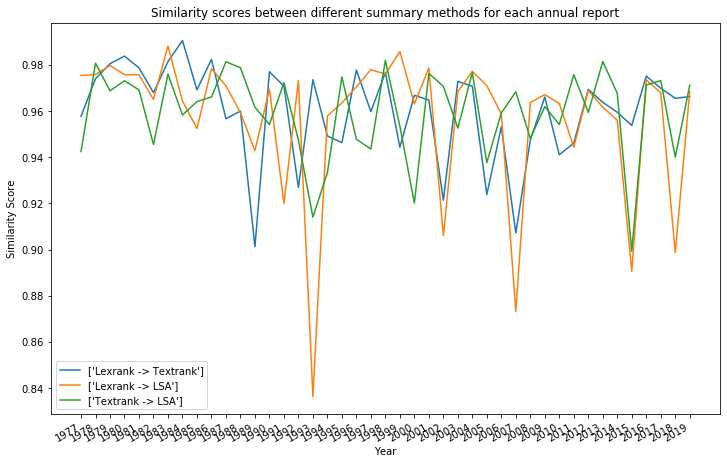

In [20]:
# If the graph does not appear, try running the cell again.

f, ax = plt.subplots(figsize=(12, 8))
plt.plot(similarity_ab)
plt.plot(similarity_ac)
plt.plot(similarity_bc)
plt.legend([['Lexrank -> Textrank'], ['Lexrank -> LSA'], ['Textrank -> LSA']])

ax.set_title(
    'Similarity scores between different summary methods for each annual report'
)
ax.set_xticks([x for x in range(43)])
ax.set_xticklabels([str(x) for x in range(1977, 2020)])
ax.set_ylabel('Similarity Score')
ax.set_xlabel('Year')

f.autofmt_xdate()
plt.savefig('../Outputs/Charts/Similarity_Scores.png')
plt.show()

Creating the summaries and exporting them to a text file.

In [21]:
def write_summaries_to_file(new_summary_file, file_name):
    '''Writes the summaries created by create_summary to a file'''

    if os.path.isfile(
            f'../Outputs/Summaries/{file_name}_summaries.txt') == False:
        for year, summary in enumerate(new_summary_file, 1977):
            paragraph = ' '.join(map(str, summary))
            with open(f'../Outputs/Summaries/{file_name}_summaries.txt',
                      'a',
                      encoding='utf-8',
                      errors='ignore') as outfile:
                outfile.write(f'{year} : {paragraph}' + '\n' + '\n')

Use the function above to write the paragraphs of the yearly summaries to a file.

In [22]:
write_summaries_to_file(lexrank_summaries, "LexRank_Summaries")
write_summaries_to_file(textrank_summaries, "TextRank_Summaries")
write_summaries_to_file(lsa_summaries, "LSA_Summaries")

<h2 align='center'> Part 4: Topic Modeling</h2> <br>

Adding several stop words that showed up in original topics. Pronouns in general are not helpful and ambiguous.

In [23]:
nlp.Defaults.stop_words |= {
    'berkshire', 'berkshires', 'berkshire hathaway', 'billion', 'billions',
    'buffett', 'million', 'millions', 'month', 'number', '_number'
    'that', 'they', 'this', 'which', 'what', 'year', 'years'
}
stop_words = nlp.Defaults.stop_words

Getting the letters post-Textacy cleaning 

In [24]:
annual_letters = dict()
for year in range(1977, 2020):
    file = f'../Letters/clean_letters/{year}_letter.txt'
    with open(file=file, encoding='utf-8', errors='ignore') as f:
        annual_letters[str(year)] = str(f.readlines())

Summary statistics, including word count and grade level.

In [25]:
textacy_corpus = textacy.corpus.Corpus(nlp, annual_letters)

grade_level = 0
word_count = 0
readability_scores = 0
readability_score = 0

for year in tqdm(annual_letters):
    tdoc = textacy.make_spacy_doc(annual_letters[year])
    word_count += textacy.TextStats(tdoc).basic_counts['n_words']
    grade_level += textacy.TextStats(tdoc).flesch_kincaid_grade_level
    readability_scores += textacy.TextStats(tdoc).flesch_reading_ease
average_grade_level = grade_level / len(annual_letters)
readability_score = readability_scores / len(annual_letters)
print(
    f'There are {word_count} words at an average grade level of {round(average_grade_level, 2)}.',
    f'Readability score of {round(readability_score)}.'
)


There are 505978 words at an average grade level of 10.09. Readability score of 58.


Removing aspects of raw text. This will be done for topic modeling.

In [26]:
def textacy_replace_remove(words):
    '''Replaces currency symbols, numbers, phone numbers, URLs, accents, and most punctuation.'''

    words = textacy.preprocessing.replace.replace_currency_symbols(
        words, replace_with='*$*')
    words = textacy.preprocessing.replace.replace_numbers(words,
                                                          replace_with='*#*')
    words = textacy.preprocessing.replace.replace_phone_numbers(
        words, replace_with='*-*')
    words = textacy.preprocessing.replace.replace_urls(words,
                                                       replace_with='*URL*')
    words = textacy.preprocessing.remove.remove_accents(words)
    words = textacy.preprocessing.remove.remove_punctuation(
        words, marks='!"#$%&\'()*+,-/:;<=>?@[\\]^`{|}~')

    return words

Cleaning the letters for Topic Modeling purposes. The "Date" labels take out things like "last year", which doesn't add value to the model. Cardinal and money take out digits that are hard on the model to analyze properly.

In [27]:
text_data = []

# Iterates through each article in the corpus.
for year in tqdm(annual_letters):
    # Passes that article through the pipeline and adds to a new list.
    textacy_letter = textacy_replace_remove(annual_letters[year])

    tokenized_letter = nlp(textacy_letter)

    bigrams = textacy.extract.ngrams(tokenized_letter,
                                     2,
                                     min_freq=2,
                                     filter_nums=True,
                                     filter_punct=True,
                                     filter_stops=True)

    trigrams = textacy.extract.ngrams(tokenized_letter,
                                      3,
                                      min_freq=2,
                                      filter_nums=True,
                                      filter_punct=True,
                                      filter_stops=True)

    entities = [
        ent for ent in tokenized_letter.ents
        if ent.label_ not in ['DATE', 'CARDINAL', 'MONEY']
    ]

    entities.extend(bigrams)
    entities.extend(trigrams)

    lower = [str(ent).lower() for ent in entities]

    no_digits = [re.sub(r'[^a-zA-Z\s]', '', ent) for ent in lower]

    strip_whitespace = [ent.strip() for ent in no_digits]

    hyphened = [re.sub(r'\s', '_', ent) for ent in strip_whitespace]

    potential_words = [chunk for chunk in hyphened if len(chunk) > 3]

    potential_words = [
        topic for topic in potential_words if topic not in stop_words
    ]
    text_data.append(potential_words)

Creating a dictionary and corpus from the text data.

In [28]:
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

Create a function to compute coherence score for model varying by number of topics.

In [29]:
def compute_coherence_model(corpus,
                            dictionary,
                            passes=50,
                            min_topics=5,
                            max_topics=15):
    """Computes a list of coherence scores for each number of topics given."""

    coherence_model_scores = []
    for n in tqdm(range(min_topics, max_topics)):
        model = gensim.models.ldamodel.LdaModel(corpus,
                                                id2word=dictionary,
                                                num_topics=n,
                                                passes=passes,
                                                per_word_topics=True,
                                                random_state=42)
        coherence_model_lda = CoherenceModel(model,
                                             texts=text_data,
                                             dictionary=dictionary,
                                             coherence='c_v',
                                             processes=-1)
        coherence_model_scores.append(coherence_model_lda.get_coherence())
    return coherence_model_scores

Applying above function to corpus to output score between 0 and 1 (higher -> more cohesive topics)

In [30]:
coherence_model_scores = compute_coherence_model(corpus=corpus,
                                                 dictionary=dictionary)

Plotting the coherence scores for each number of topics in the topic model.

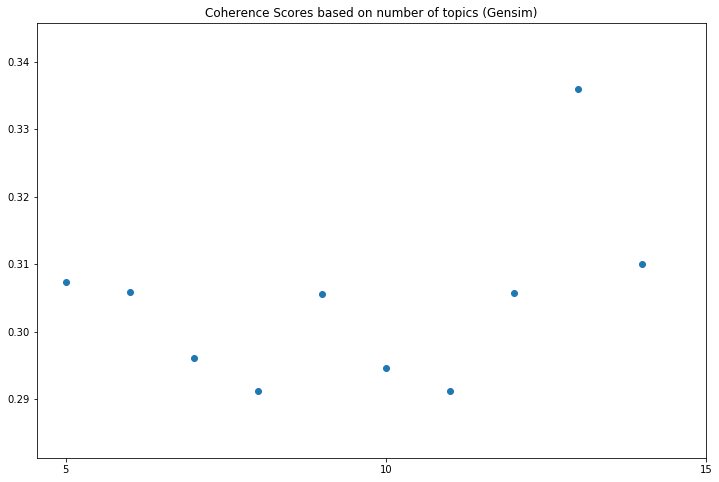

<Figure size 432x288 with 0 Axes>

In [31]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter([x for x in range(5, 15)], coherence_model_scores)
ax.set_title('Coherence Scores based on number of topics (Gensim)')
ax.set_xticks([5 * x + 5 for x in range(3)])
plt.show()
plt.savefig(f'../Outputs/Charts/Gensim_Coherence')

Building an LDA model with the highest coherence score.

In [32]:
NUM_TOPICS = coherence_model_scores.index(max(coherence_model_scores)) + 5
ldamodel = gensim.models.ldamodel.LdaModel(
    corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=50,
    per_word_topics=True,
)
ldamodel.save('../Outputs/Models/Gensim_LDA/ldamodel.model')

Plotting the topics. The X and Y axis are generated using Principal Component Analysis. The main things to look for are the size of the bubbles and which bubbles overlap (similar topics).

In [33]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, mds='mmds')
pyLDAvis.save_html(vis, '../Outputs/Charts/gensim_topic_plot.html')
pyLDAvis.display(vis)

To compare, I am going to experiment with Mallet LDA. See http://mallet.cs.umass.edu/topics.php for details. For the rest of the notebook to work, download the Mallet Package from http://mallet.cs.umass.edu/download.php and change the mallet path to the right location on your drive. Relative references don't work for this.

In [34]:
# Setup mallet environment change it according to your drive
os.environ.update({
    'MALLET_HOME':
    r'C:/Users/Tom/Documents/Berkshire/Berkshire_Final_Report/mallet-2.0.8'
})

# Setup mallet path change it according to your drive
mallet_path = 'C:/Users/Tom/Documents/Berkshire/Berkshire_Final_Report/mallet-2.0.8/bin/mallet'

Generating Coherence model scores.

In [35]:
coherence_model_scores = []
for n in tqdm(range(5, 16)):
    model = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             num_topics=n,
                                             id2word=dictionary,
                                             random_seed=42)
    coherence_model_mallet = CoherenceModel(model,
                                            texts=text_data,
                                            dictionary=dictionary,
                                            coherence='c_v')
    coherence_model_scores.append(coherence_model_mallet.get_coherence())

Plotting Coherence Scores based on number of topics.

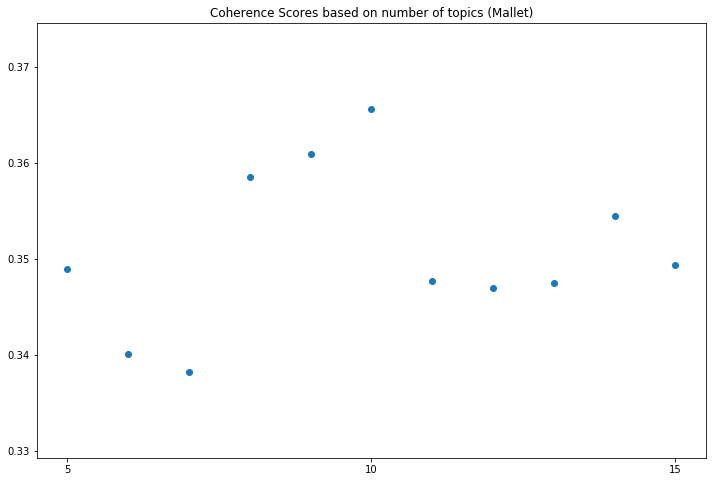

<Figure size 432x288 with 0 Axes>

In [36]:
f, ax = plt.subplots(figsize=(12, 8))
plt.scatter([x for x in range(5, 16)], coherence_model_scores)
ax.set_title('Coherence Scores based on number of topics (Mallet)')
ax.set_xticks([5 * x + 5 for x in range(3)])
plt.show()
plt.savefig(f'../Outputs/Charts/Mallet_Coherence')

Visualizing the Mallet LDA topic model.

In [37]:
NUM_TOPICS = 10
model = gensim.models.wrappers.LdaMallet(mallet_path,
                                         corpus=corpus,
                                         num_topics=NUM_TOPICS,
                                         id2word=dictionary)
ldamodel = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)
ldamodel.save('../Outputs/Models/Mallet_LDA/mallet.model')

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, mds='mmds')
pyLDAvis.save_html(vis, '../Outputs/Charts/mallet_topic_plot.html')
pyLDAvis.display(vis)

For each topic, print the top 10 words and their weights.

In [38]:
# later on, load trained model from file
mallet_model = gensim.models.LdaModel.load(
    '../Outputs/Models/Mallet_LDA/mallet.model')
pprint.pprint(
    model.show_topics(num_topics=NUM_TOPICS, num_words=10, formatted=True))

[(0,
  '0.025*"years_ago" + 0.015*"long_term" + 0.015*"long_time" + '
  '0.014*"stock_market" + 0.014*"market_value" + 0.014*"berkshire_shares" + '
  '0.012*"net_worth" + 0.012*"ben_graham" + 0.012*"retained_earnings" + '
  '0.012*"charlie_munger"'),
 (1,
  '0.021*"charlie" + 0.013*"nebraska_furniture_mart" + 0.012*"years_ago" + '
  '0.012*"recent_years" + 0.011*"netjets" + 0.010*"low_cost" + '
  '0.010*"reported_earnings" + 0.010*"nebraska_furniture" + '
  '0.010*"fractional_ownership" + 0.009*"pre_tax"'),
 (2,
  '0.033*"business_value" + 0.025*"intrinsic_business" + '
  '0.025*"intrinsic_business_value" + 0.020*"geico" + '
  '0.017*"nebraska_furniture_mart" + 0.014*"book_value" + 0.014*"blue_chip" + '
  '0.013*"goodwill" + 0.013*"market_value" + 0.012*"nebraska_furniture"'),
 (3,
  '0.023*"gaap" + 0.019*"charlie" + 0.015*"american" + 0.014*"intrinsic_value" '
  '+ 0.013*"annual_meeting" + 0.012*"berkshire_hathaway" + 0.011*"kraft_heinz" '
  '+ 0.011*"book_value" + 0.011*"omaha" + 0.0

Creating a dataframe of topic weights for each year. Saving the dataframe.

In [39]:
df = pd.DataFrame(model[corpus])
df = df.applymap(lambda x: (0, 0) if x is None else x)
topic_weights = df.applymap(lambda x: x[1])
topic_weights['year'] = [x for x in range(1977, 2020)]

topic_weights = topic_weights.set_index('year')
topic_names = [f'T{x + 1}' for x in range(NUM_TOPICS)]
topic_weights.columns = topic_names
topic_weights.to_csv('../Outputs/Models/topic_weights.csv')

For a finishing touch, here is a stacked bar graph showing how the topic weights change by letter.

In [40]:
df = topic_weights
source = ColumnDataSource(df)

df.columns = [f'T{x + 1}' for x in range(len(df.columns))]
p = figure(title='Topic Allocation over Time',
           x_axis_label='Year',
           y_axis_label='Topic Allocation',
           plot_height=500,
           plot_width=800)

p.vbar_stack(stackers=[f'{x}' for x in df.columns],
             x='year',
             source=source,
             width=.8,
             color=bokeh.palettes.Spectral[len(df.columns)])

hover = HoverTool()
hover.tooltips = [('Year', '@year'), ('Topic 1', '@T1'), ('Topic 2', '@T2'),
                  ('Topic 3', '@T3'), ('Topic 4', '@T4'), ('Topic 5', '@T5'),
                  ('Topic 6', '@T6'), ('Topic 7', '@T7'), ('Topic 8', '@T8'),
                  ('Topic 9', '@T9'), ('Topic 10', '@T10')]

p.add_tools(hover)
output_file('../Outputs/Charts/Topic_Allocation.html')
show(p)